In [ ]:
# Written by Timur Öner. For any suggestions please contact timur.oner97@gmail.com. 

# Ver 1.00, Date: 27 Nov 2022

In [1]:
# Importing the libraries.

import numpy as np
import pandas as pd
from google.colab import drive
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [2]:
drive.mount('/content/drive',force_remount=True)
%cd /content/drive/MyDrive/sunspotSupervised

Mounted at /content/drive
/content/drive/MyDrive/sunspotSupervised


In [3]:
import datapreparationmodule

In [4]:
df = pd.read_csv('sunSpotData.csv')

In [5]:
df.head()

,Month,Monthly sunspot number
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [6]:
df.isnull().sum()   # There are no missing values in our dataset.

Month                     0
Monthly sunspot number    0
dtype: int64

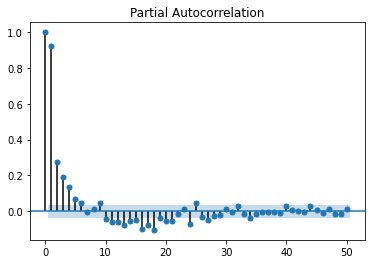

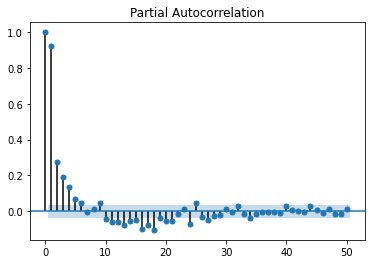

In [7]:
# Visualizing the partial autocorrelation. This visualization
# helps when deciding the window length.

plot_pacf(df['Monthly sunspot number'], lags=50)




In [8]:
# The parameters for generation of the train and testing data for our model.

dataParams = {}
dataParams['dt'] = 1                # This value should remain as 1 in the current version of the code to avoid unexpected results.
dataParams['startDate'] = '1870-01'
dataParams['endDate'] = '1975-12'
dataParams['trainingPrec'] = 0.8    # The precentage of the data that will be used for training of the model.

In [9]:
trainArray,trainTime,testArray,testTime = datapreparationmodule.generateData(df,dataParams)

In [10]:
# Smoothing of the array to ensure better performance.
trainArraySmoothed = datapreparationmodule.smoothTimeSeries(trainArray,10)

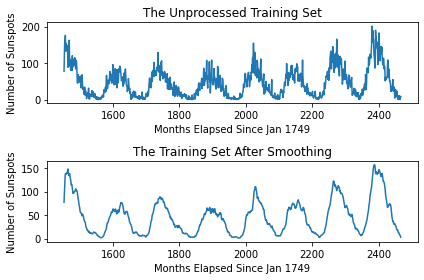

In [11]:
# Plot of the data which will be fed to our algorithm.

fig, axs = plt.subplots(2)


axs[0].plot(trainTime,trainArray)
axs[0].set_title('The Unprocessed Training Set')
axs[0].set_xlabel('Months Elapsed Since Jan 1749')
axs[0].set_ylabel('Number of Sunspots')

axs[1].plot(trainTime,trainArraySmoothed)
axs[1].set_title('The Training Set After Smoothing')
axs[1].set_xlabel('Months Elapsed Since Jan 1749')
axs[1].set_ylabel('Number of Sunspots')

fig.tight_layout()


In [12]:
windowLength = 25 # Defining the window length.

In [13]:
XTrain,yTrain,normalizationParams = datapreparationmodule.timeseriesIntoSupervised(trainArraySmoothed,windowLength,nout=1) # Generation of the data.

In [14]:
regressor = RandomForestRegressor(verbose=1, random_state = 42,n_estimators=100) # The model instance.

In [15]:
# Generating the parameter grid for hyperparameter search.

paramGrid =  {
    
    'bootstrap': [True, False],
    'min_samples_leaf' : [10,15,20,50,60,70,120,140,160,200,250,300],
    'min_samples_split' : [10,20,30,60,100,150,200,300],
    'max_features' : ['sqrt','log2','auto'],
    'max_depth' : [5,10,15,30,40,50,80,120]
    
    }
 

In [ ]:
clf = RandomizedSearchCV(regressor,paramGrid,refit=True,n_jobs=1,random_state=42,n_iter=200,verbose=3,scoring='neg_root_mean_squared_error')
search = clf.fit(XTrain,yTrain.ravel())  # Finding the best set of parameters.

In [25]:
paramsRandomForest = search.best_params_

In [26]:
paramsRandomForest # Listing the best parameters.

{'min_samples_split': 30,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 120,
 'bootstrap': True}

In [27]:
regressor.set_params(**paramsRandomForest)   # Setting the parameters.

RandomForestRegressor(max_depth=120, max_features='log2', min_samples_leaf=10,
                      min_samples_split=30, random_state=42, verbose=1)

In [28]:
regressor.fit(XTrain,yTrain.ravel())  # Fitting the regressor with the tuned parameters.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(max_depth=120, max_features='log2', min_samples_leaf=10,
                      min_samples_split=30, random_state=42, verbose=1)

In [29]:
# Generating test array.
testArraySmoothed = datapreparationmodule.smoothTimeSeries(testArray,10) 
XTest,yTest,normalizationParams = datapreparationmodule.timeseriesIntoSupervised(testArraySmoothed,windowLength,nout=1) 

In [ ]:
yPred = regressor.predict(XTest) # Prediction using our trained model.
mean_squared_error(yTest.ravel(), yPred) # The MSE of our prediction (normalized).

In [32]:
timeSeriesPred = datapreparationmodule.supervisedIntoTimeseries(XTest,yPred,normalizationParams) # Converting predictions to time series.

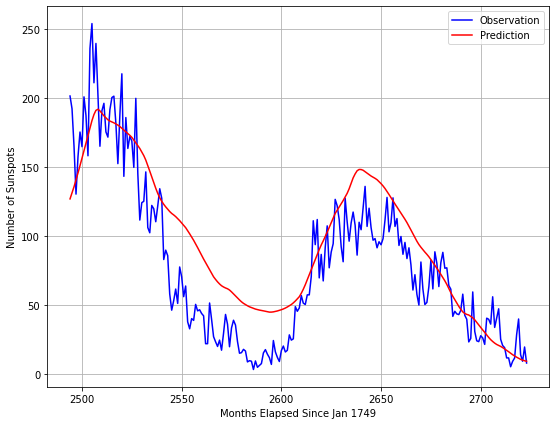

In [33]:
# Visualizing the results. 
plt.figure(figsize=(9,7))
plt.plot(testTime[windowLength::],testArray[windowLength::],'b')
plt.plot(testTime[windowLength::],timeSeriesPred[windowLength::],'r')
plt.title('')
plt.xlabel('Months Elapsed Since Jan 1749')
plt.ylabel('Number of Sunspots')
plt.legend(['Observation','Prediction'])
plt.grid(True)